In [24]:
# setting up the data.
import numpy as np
from matplotlib import pyplot
%matplotlib inline

In [19]:
data = np.load('data/strokes.npy')
print('the size of data',data.shape)



('the size of data', (6000,))


In [338]:
data_x = []
data_y = []
for i in range(len(data)):
    cur_data = data[i]
    for j in range(cur_data.shape[0]):
        if cur_data[j,0] == 1:
            data_x.append(cur_data[j,1])
            data_y.append(cur_data[j,2])
data_means = (np.mean(data_x),np.mean(data_y))
data_stds = (np.std(data_x),np.std(data_y))
print('the data has mean',data_means, 'and std',data_stds)

('the data has mean', (0.45000002, 0.04828767), 'and std', (0.6908155, 0.5390064))


In [21]:
# max sequence size
seq_len = []
for i in range(len(data)):
    seq_len.append(data[i].shape[0])
print('max', max(seq_len),'min',min(seq_len),'mean',np.mean(seq_len))
mean = np.mean(seq_len)
seq_skew = []
for i in range(len(data)):
    seq_skew.append(data[i].shape[0]>mean)
print(sum(seq_skew),' are > mean')
# not very skewed

('max', 1191, 'min', 301, 'mean', 644.2076666666667)
(2753, ' are > mean')


In [355]:
# max action size

seq_len = []
for i in range(len(data)):
    seq_len.append(np.max(data[i]))
print('max', max(seq_len))

# check ratio of pen up and down:

seq_len = np.zeros((0))
for i in range(len(data)):
    seq_len = np.concatenate([seq_len,data[i][:,0]],0)
print(np.mean(seq_len))


('max', 96.15)
0.039828254139581284


In [17]:
# dataset_script

# with only down strokes 
# ('the data has mean', (0.0422648, 0.56823623), 'and std', (0.20119265, 1.120318))
# with all strokes:
# ('the data has mean', (0.039828256, 0.41248125), 'and std', (0.19555554, 2.0786476))
# In the paper, the data is normalized first.
import global_variables as gv
import numpy as np
import random

class dataloader():
    
    def __init__(self,batch_limit,data_start, data_end, data_loc=gv.data_loc):
        self.all_data = np.load(data_loc)
        self.all_data = [self.all_data[i] for i in range(data_start,data_end)]
        self.means = gv.means
        self.stds = gv.stds
        self.shuffled_index = range(len(self.all_data))
        random.shuffle(self.shuffled_index)
        self.all_data = [self.all_data[i] for i in self.shuffled_index]
        self.batch_limit = batch_limit
        
    def shuffle_index():
        random.shuffle(self.shuffled_index)
        self.all_data = [self.all_data[i] for i in self.shuffled_index]
        
    def get_next_count(self,data,new_ar):
        new_data = [x for x in data]
        new_data.append(new_ar)
        size = [len(x) for x in new_data]
        total = max(size)*len(new_data)
        #print(total)
        return total
    def get_data(self,epoch_size=gv.epoch_size):
        cur_data_iter = 0
        while(cur_data_iter<epoch_size):
#             'returned here')
            data = []
            count = 0
            while(self.get_next_count(data,self.all_data[cur_data_iter])<self.batch_limit):
                data.append(self.all_data[cur_data_iter])
                cur_data_iter +=1
                if cur_data_iter>=epoch_size: break
            data_inp = [np.concatenate([np.zeros((1,3)), x[:-1]],0) for x in data]
            yield data_inp,data
        

            
        


AttributeError: 'module' object has no attribute 'epoch_size'

In [357]:
x = dataloader(4000,0,5500)
data_iter = x.get_data()
data_inp,data_gt = next(data_iter)


In [330]:

cat_target = np.concatenate(data_gt,axis=0)
x_gt = torch.autograd.Variable(torch.FloatTensor(cat_target[:,1]))
y_gt = torch.autograd.Variable(torch.FloatTensor(cat_target[:,2]))
pen_down_gt = torch.autograd.Variable(torch.FloatTensor(cat_target[:,0]))

In [284]:
import torch
from torch.autograd import Variable

seq_lengths = map(len, data)
limit = max(seq_lengths)
seq_tensor = Variable(torch.zeros((limit,len(data),3)))
sorted_ind = np.argsort(seq_lengths)[::-1]
for idx, (sample, seqlen) in enumerate(zip(data, seq_lengths)):
    seq_tensor[:seqlen, sorted_ind[idx], :] = torch.FloatTensor(sample)
    
seq_lengths.sort(reverse=True)
# seq_lengths, perm_idx = seq_lengths.sort(0, descending=True)
# seq_tensor = seq_tensor[perm_idx]
pack = torch.nn.utils.rnn.pack_padded_sequence(seq_tensor,seq_lengths)
hx = torch.autograd.Variable(torch.zeros(1,len(data), 300))    

In [285]:
network = simple_GRU(3, 300,121)
output = network.gru_1(pack, hx)

In [286]:
unpacked, unpacked_len = torch.nn.utils.rnn.pad_packed_sequence(output[0])
unsort_pattrn  = np.argsort(sorted_ind)
inp_linear = []
for j in unsort_pattrn:
    inp_linear.append(unpacked[:unpacked_len[j],j,:])
#print(inp_linear[0].size(),inp_linear[1].size())
inp_linear = torch.cat(inp_linear,0)

In [287]:
output = network.linear(inp_linear)
print(output.size())

torch.Size([3264, 121])


In [288]:
def get_mixture_coef(output):
    z = output # pen states
    z_pi, z_mu1, z_mu2, z_sigma1, z_sigma2, z_corr = torch.split(z[:, :-1], 20, 1)
    pen_down_prob = torch.sigmoid(z[:,2])

    # process output z's into MDN paramters
    # softmax all the pi's and pen states:
    z_pi = torch.nn.functional.softmax(z_pi)
    # all our actions
    z_mu1 =  2/math.pi*40*torch.atan(z_mu1)
    z_mu2 =  2/math.pi*40*torch.atan(z_mu2)

    # exponentiate the sigmas and also make corr between -1 and 1.
    z_sigma1 = torch.exp(z_sigma1)
    z_sigma2 = torch.exp(z_sigma2)
    z_corr = 0.99* 2/math.pi*torch.atan(z_corr)

    r = [pen_down_prob,z_pi, z_mu1, z_mu2, z_sigma1, z_sigma2, z_corr]
    return r

def normal_2d_pdfval(x1, x2, mu1, mu2, s1, s2, rho):
    norm1 = x1- mu1
    norm2 = x2- mu2
    s1s2 = s1*s2
    # eq 25
    z = torch.pow(norm1/s1,2) + torch.pow(norm2/s2,2) - 2 * rho*norm1*norm2/s1s2
    neg_rho = 1 - torch.pow(rho,2)
    result = torch.exp(-z/(2 * neg_rho))
    denom = 2 * np.pi * s1s2* torch.sqrt(neg_rho)+1e-20
    #print(np.unique(np.sign(result.cpu().data.numpy())),'result')
    #print(np.unique(np.sign(denom.cpu().data.numpy())),'denom')
    result = result/denom
    # print(result.size())
    return result

def loss_distr(pen_down_prob, z_pi, z_mu1, z_mu2, z_sigma1, z_sigma2, z_corr,x1_data, x2_data,pen_data):
    """Returns a loss fn based on eq #26 of http://arxiv.org/abs/1308.0850."""
    # This represents the L_R only (i.e. does not include the KL loss term).
    x1_data = torch.stack((x1_data,)*20,1)
    x2_data = torch.stack((x2_data,)*20,1)
    
    result0 = normal_2d_pdfval(x1_data, x2_data, z_mu1, z_mu2, z_sigma1, z_sigma2,z_corr)
    #print('result 0',np.unique(np.sign(result0.cpu().data.numpy())))
    epsilon = 1e-6
    #print(np.unique(z_pi.data.cpu().numpy()>=0))
    # result1 is the loss wrt pen offset (L_s in equation 9 of
    # https://arxiv.org/pdf/1704.03477.pdf)
    result1 = result0* z_pi
    result1 = torch.sum(result1, 1) + epsilon
    result1 = -torch.log(result1)  # avoid log(0)

    #fs = 1.0 - pen_data[:, 2]  # use training data for this
    #fs = torch.reshape(fs, [-1, 1])
    # Zero out loss terms beyond N_s, the last actual stroke
    #result1 = result1* fs

    # result2: loss wrt pen state, (L_p in equation 9)
    # modify pendata to be 2 channel
    # add softmax loss
    result2 = softmax_loss(
             labels=pen_data, logits=pen_down_prob)
    #result2 = tf.reshape(result2, [-1, 1])
    #if not self.hps.is_training:  # eval mode, mask eos columns
    #    result2 = result2* fs
    result = torch.mean(result1) #+ result2
    return result


Variable containing:
 3.2722
[torch.FloatTensor of size 1]

In [289]:

pen_down_prob,o_pi, o_mu1, o_mu2, o_sigma1, o_sigma2, o_corr = get_mixture_coef(output)
loss_distr = loss_distr(o_pi, o_mu1, o_mu2, o_sigma1, o_sigma2, o_corr, x_gt, y_gt)
loss_sigmoid =  torch.nn.BCELoss()
# print(type(pen_down_prob.data),type(pen_down_gt.data))
loss = loss_sigmoid(pen_down_prob,pen_down_gt)
loss



In [361]:

optimizer = torch.optim.Adam(network.parameters(), 0.001,weight_decay=0.0001)

In [233]:
# models script
import torch
import torchvision.models as models
import time
import os
import random
import math
import torch.nn as nn
# import tensorboardX as tb

class simple_GRU(nn.Module):
    
    def __init__(self, inp_size, hidden_size_1,output_size):
        super(simple_GRU, self).__init__()
        self.gru_1 = nn.GRU(inp_size, hidden_size_1)
        self.linear = nn.Linear(hidden_size_1,output_size)

        # for training
        self.drop = nn.Dropout(0.4)
        self.relu = nn.ReLU()

    def forward(self,input, hidden, train=True):
        # assuming tensor input k*3
        ln, hn = self.gru_1(input, hidden)
        rearranged = ln.squeeze(1)
        if train: rearranged = self.drop(rearranged)
        out1 = self.linear(self.relu(rearranged))
        return out1




    



In [10]:
import torch
import torch.backends.cudnn as cudnn
import data_loader
import utils
import global_variables as gv
import models
import argparse
# import tensorboardX
import numpy as np

def setup(cuda,device_id=0):
    if cuda:
        torch.cuda.set_device(device_id)
    train_data_loader = data_loader.dataloader(gv.batch_limit,gv.train_start_index,gv.train_end_index)
    val_data_loader = data_loader.dataloader(gv.batch_limit,gv.val_start_index,gv.val_end_index)
    network = models.simple_GRU(3,gv.gru_size,121)
    network.cuda()
    # init the network with orthogonal init and gluroot.
    # network.wt_init()
    
    graves_output = models.graves_output()
    
    # Optimizer 
    optimizer = torch.optim.Adam(network.parameters(), gv.orig_lr, weight_decay=gv.weight_decay)
    
    # for le rumours 
    cudnn.benchmark = True
    
    return train_data_loader, val_data_loader, network, graves_output, optimizer


In [13]:
reload(models)

<module 'models' from 'models.pyc'>

In [3]:

def train(train_data_loader, network, graves_output,optimizer):
    
    data_fetcher = train_data_loader.get_data()
    for iter,(data,data_gt) in enumerate(data_fetcher):
        if iter%100 == 0 : print('cur_iter',iter)
        cat_target = np.concatenate(data_gt,axis=0)
        x_gt = torch.autograd.Variable(torch.FloatTensor(cat_target[:,1]))
        y_gt = torch.autograd.Variable(torch.FloatTensor(cat_target[:,2]))
        pen_down_gt = torch.autograd.Variable(torch.FloatTensor(cat_target[:,0]))
        output = network.forward_unlooped(data,cuda=True)
        pen_down_prob,o_pi, o_mu1, o_mu2, o_sigma1, o_sigma2, o_corr = graves_output.get_mixture_coef(output)
        loss_distr = graves_output.loss_distr(o_pi, o_mu1, o_mu2, o_sigma1, o_sigma2, o_corr, x_gt, y_gt)
        
        
        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss_distr.backward()
        optimizer.step()
        
def val(val_data_loader,network,graves_output):
    return loss

In [ ]:
train_data_loader, val_data_loader, network, graves_output,optimizer = setup(True,0)
for epoch in range(gv.total_epochs):
    utils.adjust_learning_rate(optimizer, epoch,gv.orig_lr)
    train_data_loader.shuffle_index()
    train(train_data_loader, network, graves_output,optimizer)
    print('==========TRAIN Epoch',iter+1,"COMPLETE ====================")
    loss = val(val_data_loader,network,graves_output)
    print('==========val Epoch',iter+1,"COMPLETE ====================")
    # add a is best checker
    utils.save_checkpoint({
           'epoch': epoch + 1,
           'arch': 'res18',
           'loss': loss,
           'model_state_dict': network.state_dict(),
           'optimizer' : optimizer.state_dict(),
        },filename = 'weights/simple_GRU_'+str(epoch+1)+'.pth')


In [61]:
def plot_stroke_numpy(stroke, save_name=None):
    # Plot a single example.
    f, ax = pyplot.subplots()
    x = np.cumsum(stroke[:, 1])
    y = np.cumsum(stroke[:, 2])

    size_x = x.max() - x.min() + 1.
    size_y = y.max() - y.min() + 1.

    f.set_size_inches(5. * size_x / size_y, 5.)

    cuts = np.where(stroke[:, 0] == 1)[0]
    start = 0

    for cut_value in cuts:
        ax.plot(x[start:cut_value], y[start:cut_value],
                'k-', linewidth=3)
        start = cut_value + 1
    ax.axis('equal')
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    
    f.tight_layout(pad=0)
    f.canvas.draw()
    data = np.fromstring(f.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    data = data.reshape(f.canvas.get_width_height()[::-1]+(3,))
    pyplot.close()
    return data

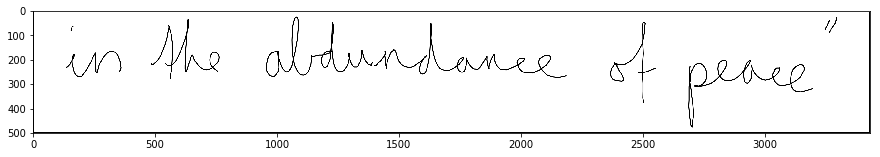

In [63]:
pyplot.figure(figsize=(15,7))
pyplot.imshow(dat)

In [64]:
data[0].shape

(739, 3)

In [62]:
dat = plot_stroke(data[0])
dat.shape

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:36: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


(500, 3433, 3)